# NoseCone Maker

**Created by:** Andrew Smelser

**Created on:** 02-14-2020

**Updated on:** 10-28-2020

## Description

A script written in Python 3.7 to create a nosecone with shoulder for a given airframe size. The nosecone will have a hollow interior with constant wall thickness of value ``k``. The coordinates of the nosecone will be produced as a 2D matrix and printed to a .csv file for use in OpenSCAD.

## Requirements
* Python 3.7.6+
* Jupyter NoteBook 6.0.2+
* Shapely 1.6.4+
* Matplotlib 3.1.1+
* Numpy 1.17.3+

## Instructions
1. Define the parameters below in cell 1 (**User Input Parameters**)
2. Click "restart the kernel, then re-run the whole notebook"
3. Wait for the NoteBook to run
4. Open the file that was just created and copy its contents
5. Paste those contents into an OpenSCAD file (alternatively change the file extension from *.csv* to *.scad*)
6. Run the OpenSCAD file
7. It should produce a nosecone with the parameters you have defined

## User Parameters
**d<sub>&gamma;</sub>** Plot resolution, same units as gamma

**ar** Length to width ratio, dimensionless

**&alpha;** Nosecone shape parameter, dimensionless

**&beta;** Aft nosecone diameter, mm. This is the same as the outer airframe diameter.

**&gamma;** Nosecone length (excluding shoulder length), mm

**k** Wall thickness, mm

**&beta;<sub>s</sub>** Shoulder outer diameter, mm. This is the same as the inner airframe diameter.

**&gamma;<sub>s</sub>** Shoulder length, mm

### Default Test Values
``dgamma = 0.1``  # plot resolution, same units as gamma

``ar = 4``  # length to width ratio, dimensionless

``alpha = 1``  # nosecone shape parameter, dimensionless

``beta = 40``  # aft nosecone diameter, mm

``gamma = ar * beta``  # nosecone length, mm

``k = 1.5``  # wall thickness, mm

``beta_s = 36``  # shoulder outer diameter, mm

``gamma_s = 38``  # shoulder length, mm

See the ``tests/NoseConeMaker`` folder for the outputs of the test.

## Notes

* Don't edit any cell other than the first cell where you will enter the user inputs.
* Currently only ``alpha = 1`` is supported. This should produce an ogive nosecone.
* Change the value of ar to achieve different types of ogive. For example ``ar = 4`` is a 4:1 ogive.
* The output file will contain several hundred lines of coordinate points, depending on the overall length of the nosecone and the value of dgamma. 
    * A value of ``dgamma = 0.1`` should be sufficient for a nosecone of 40mm long (excluding shoulder). 
* The coordinates produced can be used in other CAD programs. 
    * The nosecone profile is designed to be created by a revolve-extrude operation around the x-axis. 
    * Attempts to test a similar program as this one (transition_maker) were not successful in Solid Edge, but it is likely that it could be made to work. 
* This code was developed and tested only in Jupyter NoteBook. Attempts might be made later to transition all the code and related codes to a PyCharm project. If you attempt this and run into issues please let the developer know!
* Attempting to export the generated nosecone from OpenSCAD 2019.05 has caused the program to lock-up for me. You might run into similar issues. Try reducing the ``dgamma`` value or vodka-cooling your PC.
* This file supersedes nosecone_maker.ipynb

## TODO

* Add functionality to plot a nosecone that will include a metal tip
    * Just supply the length of the metal tip and mask the plot data
* Need to add functionality to make the nose blunted (see bullet plotter I think?)

# User Input Parameters

In [1]:
dgamma = 0.1
ar = 4
alpha = 1
beta = 40
gamma = ar * beta
k = 1.5
beta_s = 36
gamma_s = 38

# DO NOT EDIT BELOW THIS LINE
-----

In [2]:
# Define the functions that will create the nose cone

from shapely.geometry import Point, LineString
from shapely.ops import polygonize
import matplotlib.pyplot as plt
import numpy as np
import os


def xy_points(gamma, beta, alpha=1, dgamma=0.1):
    """Calculate the x and y coordinates of the nosecone
    
        :param gamma: Nosecone length, mm.
        :type gamma: int, float
        :param dgamma: incremental nosecone length for iteration, mm. Default is 0.001
        :type dgamma: float
        :param beta: Aft nosecone outer diameter, mm.
        :type beta: int, float
        :param alpha: Nosecone shape parameter; default is 1
        :type alpha: int  
    """
    curve_pts = np.arange(0, gamma+dgamma, dgamma)
    x = curve_pts
    
    x_sq = x**2  # Same as x_pts.^2 in MATLAB    
    y = beta*((-alpha*x_sq/gamma**2)+(2*x/gamma))/(2*(2-alpha))
    return x, y


def add_shoulder(x, y, beta_s, gamma_s):
    """Create the nosecone shoulder
    
        :param x: x-coordinates for the nosecone
        :type x: np.array
        :param y: y-coordinates for the nosecone
        :type y: np.array
        :param beta_s: Nosecone shoulder outer diameter, mm.
        :type beta_s: int, float
        :param gamma_s: Nosecone shoulder length, mm.
        :type gamma_s: int, float   
    """
    xy_tups = [(x[i], y[i]) for i, _ in enumerate(x)]
    sldr_stop_x0_y0 = (x[-1], y[-1])
    sldr_stop_x1_y1 = (x[-1], beta_s/2)
    sldr_end_x2_y2 = (x[-1] + gamma_s, beta_s/2)
    xy_tups.append(sldr_stop_x0_y0)
    xy_tups.append(sldr_stop_x1_y1)
    xy_tups.append(sldr_end_x2_y2)
    ln1 = LineString(xy_tups)
    return ln1


def inner_surface(outer_surface, k):
    """Create the inner surface line
    
        :param outer_surface: Shapely LineString for the outer surface
        :type outer_surface: shapely.LineString
        :param k: Wall thickness, mm.
        :type k: float    
    """
    k = float(k)  # force k to be a float
    if k < 0:
        side='left'
    elif k > 0:
        side='right'
    else:
        msg = f'Unknown error encountered when handling k value of {k}.'
        raise ValueError(msg)
    
    return outer_surface.parallel_offset(
        distance=abs(k),
        side=side,
        join_style=2)


def plot_coords(line_coords):
    """Show the plot of the lines
    
        Call transition_offset_wall(...) before calling this function

        :param line_coords: Shapely LineString object that represents the transition
        :type line_coords: shapely.LineString, list
    """
    loc_coords_copy = list()
    for _coords in line_coords:
        loc_coords = np.array([(x[0], x[1]) for x in _coords.coords])
        loc_coords_copy.append(loc_coords)

    # Upper surface 
    upper_surface = loc_coords_copy[0].T
    us_x = upper_surface[0]
    us_y = upper_surface[1]
    
    lower_surface = loc_coords_copy[1].T
    ls_x = lower_surface[0]
    ls_y = lower_surface[1]
    
    # Correct lower surface nosetip
    msk = ls_y < 0
    ls_x = np.extract(~msk, ls_x)
    ls_y = np.extract(~msk, ls_y)
    
    xx = np.concatenate([us_x, ls_x])
    yy = np.concatenate([us_y, ls_y])
    
    %matplotlib inline
    fig = plt.figure(figsize=(13,6), dpi=150)
    ax = plt.axes()
    ax.grid()
    ax.plot(xx, yy, color='g')
    ax.set_aspect('equal')
    plt.show()
    return np.vstack((xx, yy)).T


def write_to_file(coord_pairs, filename):
    """Write the coordinate pairs to a csv file

        Write coordinate pairs to a .csv file for copy and paste
        into OpenSCAD

        :param coord_pairs: A NumPy array of x and y coordinates for the nosecone
        :type coord_pairs: np.array
        :param filename: The name of the output file. Must contain the file extension. 
        :type filename: str, PathLike    
    """
    filename = os.path.join(os.getcwd(), filename)
    rows, _ = coord_pairs.shape
    i = 0
    max_length = max(coord_pairs.T[0])
    header = f"""rotate_extrude($fn=200)
\trotate([0,0,-90])
\t\ttranslate([-{max_length},0,0])
\t\t\tpolygon(
\t\t\t\tpoints=[
"""
    with open(filename, mode='w', newline='') as fout:
        fout.write(header)
        for row in coord_pairs:
            i = i + 1
            if i == rows:
                write_str = f'\t\t\t\t\t[{row[0]},{row[1]}]\n\t\t\t\t]\n\t\t\t);'                
            else:
                write_str = f'\t\t\t\t\t[{row[0]},{row[1]}],\n'
            fout.write(write_str)
    print('File created: {}'.format(filename))
    return True


def main(filename):
    """Call all functions and produce the output file
    
        :param filename: The name of the output file. Must include file extension.
        :type filename: str, PathLike
    """
    x, y = xy_points(gamma=gamma, beta=beta)
    outer = add_shoulder(x, y, beta_s, gamma_s)
    inner = inner_surface(outer, k)
    coord_pairs = plot_coords([outer, inner])
    write_to_file(coord_pairs=coord_pairs, filename=filename)
    return coord_pairs

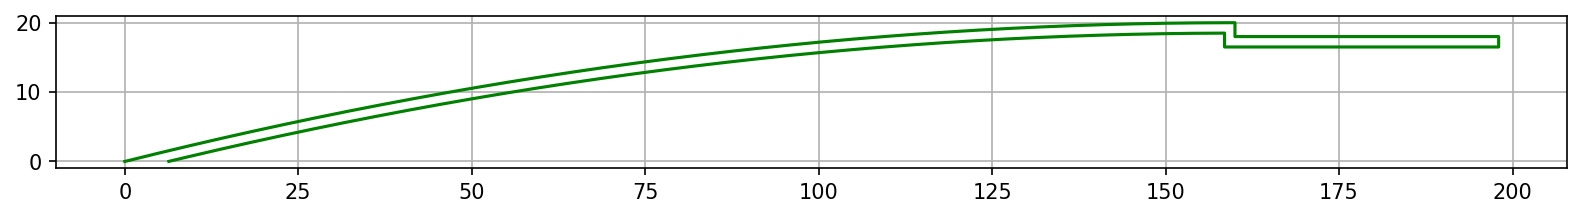

File created: C:\Users\asmelser\Documents\Python\Jupyter\JupyterNotebook\Nosecones\test_nosecone_1.scad


In [3]:
# Call the main() function to produce the output for OpenSCAD
nc = main(filename='test_nosecone_1.scad')